In [1]:
import tensorflow as tf
import keras
import os

In [14]:
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from time import time

In [5]:
TRAIN_PATH = './images-fresh-Shaima-CNN/train'
TEST_PATH = './images-fresh-Shaima-CNN/test'
CLASS_NAMES = ["hello", "help", "iloveyou", "no", "yes"]
BATCH_SIZE = 4
print(os.listdir(TRAIN_PATH))

['no', 'hello', 'yes', 'iloveyou', 'help']


Preprocessing Images

In [6]:
image_size = (180, 180)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=BATCH_SIZE,
)

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=BATCH_SIZE,    
)

print("Datasets created successfully.")

Found 39 files belonging to 5 classes.
Found 10 files belonging to 5 classes.
Datasets created successfully.


In [7]:
for images, labels in train_dataset.take(1):
    print(labels)

tf.Tensor(
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]], shape=(4, 5), dtype=float32)


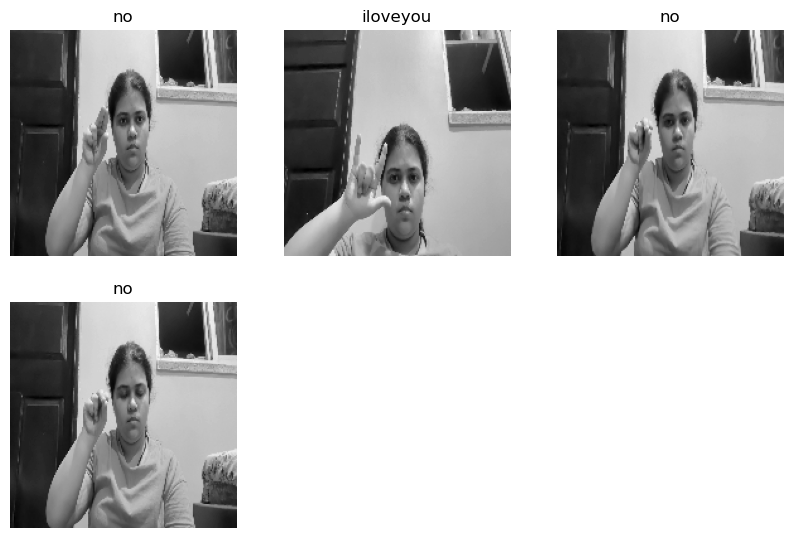

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Assuming you want to visualize from the train_dataset
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze().astype("uint8"), cmap='gray')  # Squeeze to remove the single-channel dimension
        plt.title(CLASS_NAMES[tf.argmax(labels[i]).numpy()])  # Assuming labels are one-hot encoded
        plt.axis("off")
plt.show()


Model Creation


In [22]:
# Define input shape
image_height, image_width = 180, 180
num_classes = 5

# Define the CNN model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 1)),
    layers.Conv2D(16, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [23]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      32        
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        544       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [25]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

Run `tensorboard --logdir=logs/` in a terminal before fitting

In [28]:
# Fit the model 
epochs = 10
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    callbacks = [tensorboard]
)

Epoch 1/10
10/10 [==============================] - 0s 14ms/step - loss: 3.2456e-04 - accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 2.5226e-04 - accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 2.0409e-04 - accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 1.7105e-04 - accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 1.4575e-04 - accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 1.2577e-04 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 1.0996e-04 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 9.7860e-05 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 14ms/step - loss: 8.6060e-05 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 17ms/step - loss:

In [29]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")
print("Test Accuracy:", test_accuracy)

print("Model trained and evaluated successfully.")

3/3 [==============================] - 0s 4ms/step - loss: 1.0127e-04 - accuracy: 1.0000
Test accuracy: 1.0
Test Accuracy: 1.0
Model trained and evaluated successfully.


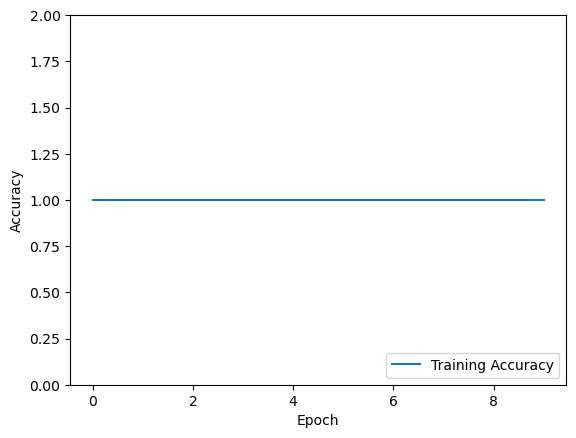

In [31]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()

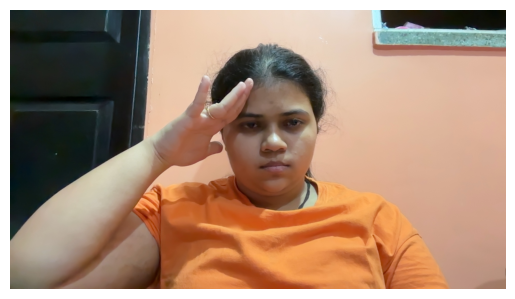

In [32]:
import numpy as np
import matplotlib.pyplot as plt

test_image_path = './images-fresh-Shaima-CNN/test/hello/hello.0715ec40-03c2-11ef-a8a4-7e09ada021c9.jpg'
# Load the test image
test_image = plt.imread(test_image_path)

# Display the test image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [33]:
# Resize the test image if necessary (assuming 'image_size' is the desired size)
image_size=[180, 180]
if test_image.shape[:2] != image_size:
    test_image = tf.image.resize(test_image, image_size)
# Convert the resized image to grayscale
test_image_gray = tf.image.rgb_to_grayscale(test_image)
test_image_gray = tf.expand_dims(test_image_gray, axis=0)  # Add batch dimension


In [34]:
# Predict the class of the test image using the trained model
predictions = model.predict(test_image_gray)

# Convert predictions to numpy array
predictions = np.array(predictions)

1/1 [==============================] - 0s 66ms/step


In [35]:
predictions

array([[9.9998260e-01, 2.6274478e-07, 8.4155226e-06, 6.5318858e-07,
        8.0652835e-06]], dtype=float32)

In [37]:
# Find the index of the maximum value in the array
predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)

# Output the predicted class label 
predicted_class_label = CLASS_NAMES[predicted_class_index]
print("Predicted class is:", predicted_class_label)

Predicted class index: 0
Predicted class is: hello


In [38]:
model.save('cnn_Shaima-test-1.h5')

/Users/shaimahaque/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
model.save('cnn_Shaima-test-1.keras')